# <div style="text-align: center"> CNN Architectures </div>
#### <div style="text-align: right"> 2019.09.19 Thursday </div>
#### <div style="text-align: right"> Prof. Changho Suh, TA Jaewoong Cho, Junhyung Ahn</div>

**실습목표**
- 수업시간에 배운 AlexNet, ResNet 생성
- CIFAR10 Data 불러오기, 데이터 확인 
- Validation 및 Early stopping 개념 이해
- AlexNet 과 ResNet에서 CIFAR10 training
- 성능비교 

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import tensorflow as tf
from tensorflow import keras as keras
import numpy as np

import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.datasets import cifar10, cifar100
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.datasets.cifar import load_batch
from tensorflow.python.keras.utils.data_utils import get_file
from tensorflow.python.util.tf_export import keras_export
from tensorflow.keras.models import load_model

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

## 1) Functions

In [3]:
def get_smooth_batch_losses(array):
    smoothing_alpha = 0.95
    output = []
    value = 0
    for i in range(len(array)):
        value = smoothing_alpha * value + (1 - smoothing_alpha) * array[i]
        output.append(value / (1 - smoothing_alpha**(i+1)))
    return output

In [4]:
def plot(cnn_batch_stats):
    plt.figure(figsize = (15,15))
    
    plt.subplot(2,2,1)
    plt.ylabel("Loss", fontsize=15)
    plt.xlabel("Training Steps", fontsize=15)
    plt.ylim([0,2])
    plt.plot(get_smooth_batch_losses(cnn_batch_stats.batch_losses))

    plt.subplot(2,2,2)
    plt.ylabel("Train Accuracy", fontsize=15)
    plt.xlabel("Training Steps", fontsize=15)
    plt.ylim([0,1])
    plt.plot(get_smooth_batch_losses(cnn_batch_stats.batch_acc))

    plt.subplot(2,2,3)
    plt.ylabel("Loss", fontsize=15)
    plt.xlabel("Epochs" , fontsize=15)
    plt.ylim([0,3])
    plt.plot(cnn_batch_stats.epoch_train_loss, label = 'train loss per epoch')
    plt.plot(cnn_batch_stats.epoch_val_loss, label = 'validation loss per epoch')
    plt.legend()
    
    plt.subplot(2,2,4)
    plt.ylabel("Accuracy", fontsize=15)
    plt.xlabel("Epochs", fontsize=15)
    plt.ylim([0,1])
    plt.plot(cnn_batch_stats.epoch_train_acc, label = 'train accuracy per epoch')
    plt.plot(cnn_batch_stats.epoch_val_acc, label = 'validation accuracy per epoch')
    plt.legend()

In [5]:
# For logging
class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []
        self.epoch_train_loss = []
        self.epoch_train_acc = []
        self.epoch_val_loss = []
        self.epoch_val_acc = []

    def on_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['acc'])

    def on_epoch_end(self, epoch, logs=None):
        self.epoch_train_loss.append(logs['loss'])
        self.epoch_train_acc.append(logs['acc'])
        self.epoch_val_loss.append(logs['val_loss'])
        self.epoch_val_acc.append(logs['val_acc'])

In [6]:
def scheduler(epoch, lr):
    if epoch == 30 or epoch ==60 : 
        lr = lr  * 0.1
    else:
        lr = lr
    return lr

## 2) Models

### 2-1) AlexNet

In [22]:
# AleXNet without Batch normalization, Dropout layer  
alexnet_model = tf.keras.models.Sequential()

#1. First Layer (Convolutional Layer)
alexnet_model.add(tf.keras.layers.Conv2D(filters=48, input_shape=(32,32,3), kernel_size=(3,3), 
                                         strides= (1,1), padding='same'))
alexnet_model.add(tf.keras.layers.Activation('relu'))
alexnet_model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2),padding = 'valid'))

#2. Second Layer (Convolutional Layer)
alexnet_model.add(tf.keras.layers.Conv2D(filters=96, kernel_size=(3,3), strides=(1,1), padding='same'))
alexnet_model.add(tf.keras.layers.Activation('relu'))
alexnet_model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2),padding = 'valid'))

#3. Third Layer (Convolutional Layer)
alexnet_model.add(tf.keras.layers.Conv2D(filters=192, kernel_size=(3,3), strides=(1,1), padding='same'))
alexnet_model.add(tf.keras.layers.Activation('relu'))

#4. Fourth Layer (Convolutional Layer)
alexnet_model.add(tf.keras.layers.Conv2D(filters=192, kernel_size=(3,3), strides=(1,1), padding='same'))
alexnet_model.add(tf.keras.layers.Activation('relu'))

#5. Fifth Layer (Convolutional Layer)
alexnet_model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
alexnet_model.add(tf.keras.layers.Activation('relu'))
alexnet_model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2),padding = 'valid'))

#6. Sixth Layer (Fully Connected Layer)
alexnet_model.add(tf.keras.layers.Flatten())
alexnet_model.add(tf.keras.layers.Dense(512))
alexnet_model.add(tf.keras.layers.Activation('relu'))

#7. Seventh Layer (Fully Connected Layer)
alexnet_model.add(tf.keras.layers.Dense(256))
alexnet_model.add(tf.keras.layers.Activation('relu'))

#8. Eighth Layer (Fully Connected Layer)
alexnet_model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))

alexnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 32, 32, 48)        1344      
_________________________________________________________________
activation_7 (Activation)    (None, 32, 32, 48)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 48)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 16, 16, 96)        41568     
_________________________________________________________________
activation_8 (Activation)    (None, 16, 16, 96)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 8, 8, 96)          0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 8, 8, 192)        

### 2-2) ResNet

In [8]:
#ResNet
input = keras.layers.Input(shape=(32, 32, 3))
x = keras.layers.Conv2D(32, kernel_size=3, padding='same', strides=(1, 1))(input)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.ReLU()(x)
x = keras.layers.Conv2D(32, kernel_size=3, padding='same', strides=(1, 1))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.ReLU()(x)
x = keras.layers.MaxPool2D(2)(x)
x = keras.layers.Conv2D(64, kernel_size=3, padding='same', strides=(1, 1))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.ReLU()(x)
skip = x
x = keras.layers.Conv2D(64, kernel_size=3, padding='same', strides=(1, 1))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.ReLU()(x)
x = keras.layers.Conv2D(64, kernel_size=3, padding='same', strides=(1, 1))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Add()([x, skip])
x = keras.layers.ReLU()(x)
x = keras.layers.MaxPool2D(2)(x)
x = keras.layers.Conv2D(128, kernel_size=3, padding='same', strides=(1, 1))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.ReLU()(x)
skip = x
x = keras.layers.Conv2D(128, kernel_size=3, padding='same', strides=(1, 1))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.ReLU()(x)
x = keras.layers.Conv2D(128, kernel_size=3, padding='same', strides=(1, 1))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Add()([x, skip])
x = keras.layers.ReLU()(x)
x = keras.layers.AveragePooling2D(pool_size=(8, 8))(x)
x = keras.layers.Flatten()(x)

# Fully-connected layer
output = keras.layers.Dense(10, activation=tf.nn.softmax)(x)
resnet = keras.models.Model(input, output)

resnet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 32, 32, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 32)   128         conv2d_5[0][0]                   
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 32, 32, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [9]:
models = {'alexnet': alexnet_model , 'resnet': resnet}

## 3) Dataset

In [10]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 1/5, stratify=y_train)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (40000, 32, 32, 3)
40000 train samples
10000 test samples


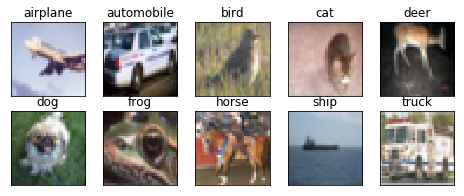

In [11]:
num_classes = 10
class_names = ['airplane','automobile',
                       'bird','cat',
                       'deer','dog',
                       'frog','horse',
                       'ship','truck']

fig = plt.figure(figsize=(8,3))

for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train[:]==i)[0]
    features_idx = x_train[idx]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

## 4) Training

### 4-1) AlexNet training

In [12]:
#Experiment setting
LRSchedule_flag = False #True or False
learning_rate = 0.001
momentum=0.9
batch_size = 128
epochs = 200

In [13]:
model_name = 'alexnet'
cnn_model = models[model_name]

# Compile CNN model
cnn_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

#model save folder path
model_save_folder_path = './model/'
if not os.path.exists(model_save_folder_path):
    os.mkdir(model_save_folder_path)

model_save_folder_path = model_save_folder_path+model_name
if not os.path.exists(model_save_folder_path):
    os.mkdir(model_save_folder_path)
    
model_path = model_save_folder_path+'/best_model.hdf5'

#collect callback
cnn_batch_stats = CollectBatchStats()
#checkpoint callback
cb_checkpoint = ModelCheckpoint(filepath=model_path, 
                                monitor='val_acc',
                                verbose=1, 
                                save_best_only=True)
#early stopping callback
cb_early_stopping = EarlyStopping(monitor='val_acc', patience=20)
#learning rate schedule callback
cb_learning_rate_schedule = LearningRateScheduler(scheduler)

if LRSchedule_flag:
    callbacks = [cnn_batch_stats, cb_checkpoint, cb_learning_rate_schedule]
else:
    callbacks = [cnn_batch_stats, cb_checkpoint, cb_early_stopping]
    
# Train CNN model
cnn_model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              callbacks=callbacks,
              validation_data=(x_val, y_val))

Train on 40000 samples, validate on 10000 samples
Epoch 1/200
39936/40000 [============================>.] - ETA: 0s - loss: 2.2934 - acc: 0.1433
Epoch 00001: val_acc improved from -inf to 0.20310, saving model to ./model/alexnet/best_model.hdf5
40000/40000 [==============================] - 6s 158us/sample - loss: 2.2934 - acc: 0.1433 - val_loss: 2.2774 - val_acc: 0.2031
Epoch 2/200
39552/40000 [============================>.] - ETA: 0s - loss: 2.1626 - acc: 0.2332
Epoch 00002: val_acc improved from 0.20310 to 0.27980, saving model to ./model/alexnet/best_model.hdf5
40000/40000 [==============================] - 5s 133us/sample - loss: 2.1607 - acc: 0.2333 - val_loss: 1.9804 - val_acc: 0.2798
Epoch 3/200
39552/40000 [============================>.] - ETA: 0s - loss: 1.9529 - acc: 0.2907
Epoch 00003: val_acc improved from 0.27980 to 0.29900, saving model to ./model/alexnet/best_model.hdf5
40000/40000 [==============================] - 6s 139us/sample - loss: 1.9519 - acc: 0.2912 - val_

Epoch 26/200
39808/40000 [============================>.] - ETA: 0s - loss: 0.8119 - acc: 0.7176
Epoch 00026: val_acc improved from 0.65630 to 0.65910, saving model to ./model/alexnet/best_model.hdf5
40000/40000 [==============================] - 5s 135us/sample - loss: 0.8117 - acc: 0.7176 - val_loss: 0.9958 - val_acc: 0.6591
Epoch 27/200
39552/40000 [============================>.] - ETA: 0s - loss: 0.7896 - acc: 0.7241
Epoch 00027: val_acc improved from 0.65910 to 0.66880, saving model to ./model/alexnet/best_model.hdf5
40000/40000 [==============================] - 5s 136us/sample - loss: 0.7904 - acc: 0.7239 - val_loss: 0.9692 - val_acc: 0.6688
Epoch 28/200
39808/40000 [============================>.] - ETA: 0s - loss: 0.7509 - acc: 0.7396
Epoch 00028: val_acc improved from 0.66880 to 0.67450, saving model to ./model/alexnet/best_model.hdf5
40000/40000 [==============================] - 5s 135us/sample - loss: 0.7505 - acc: 0.7398 - val_loss: 0.9452 - val_acc: 0.6745
Epoch 29/200


39936/40000 [============================>.] - ETA: 0s - loss: 0.0723 - acc: 0.9777
Epoch 00054: val_acc did not improve from 0.69740
40000/40000 [==============================] - 5s 136us/sample - loss: 0.0725 - acc: 0.9776 - val_loss: 1.7020 - val_acc: 0.6905
Epoch 55/200
39936/40000 [============================>.] - ETA: 0s - loss: 0.0540 - acc: 0.9844
Epoch 00055: val_acc did not improve from 0.69740
40000/40000 [==============================] - 5s 135us/sample - loss: 0.0540 - acc: 0.9844 - val_loss: 1.7302 - val_acc: 0.6898
Epoch 56/200
39552/40000 [============================>.] - ETA: 0s - loss: 0.0332 - acc: 0.9926
Epoch 00056: val_acc did not improve from 0.69740
40000/40000 [==============================] - 5s 134us/sample - loss: 0.0333 - acc: 0.9925 - val_loss: 1.8183 - val_acc: 0.6901
Epoch 57/200
39552/40000 [============================>.] - ETA: 0s - loss: 0.0137 - acc: 0.9984
Epoch 00057: val_acc did not improve from 0.69740
40000/40000 [=========================

Epoch 83/200
39936/40000 [============================>.] - ETA: 0s - loss: 5.2844e-04 - acc: 1.0000
Epoch 00083: val_acc did not improve from 0.70300
40000/40000 [==============================] - 5s 133us/sample - loss: 5.2802e-04 - acc: 1.0000 - val_loss: 2.3946 - val_acc: 0.6999


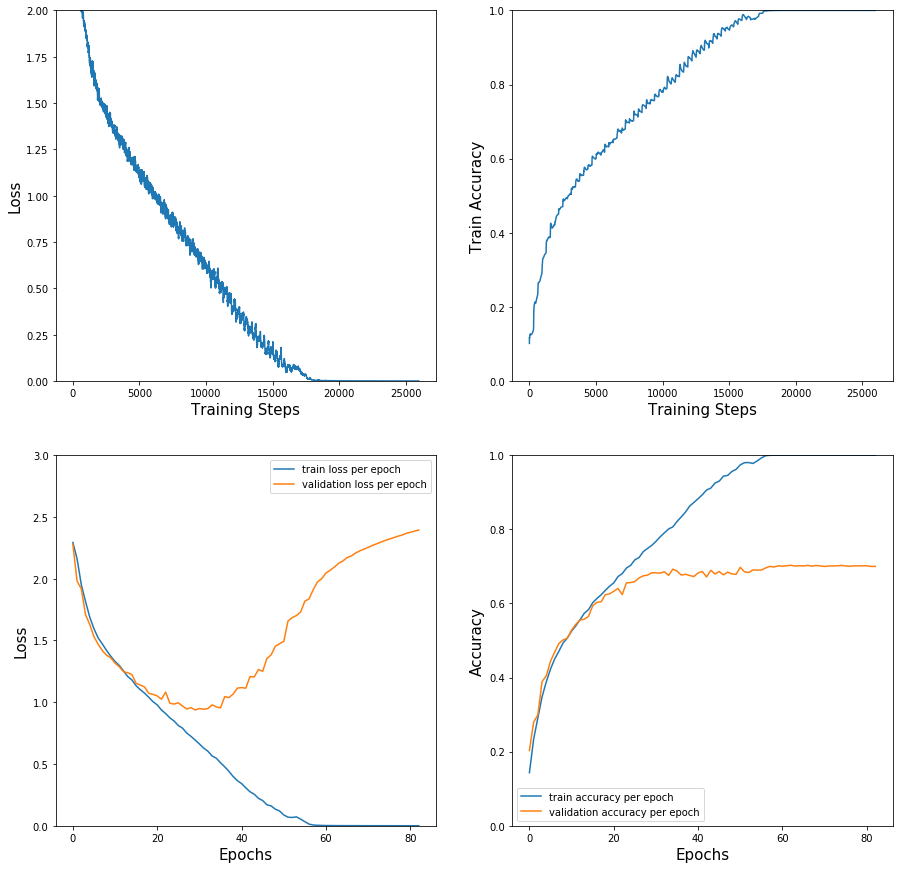

In [14]:
plot(cnn_batch_stats)

In [15]:
test_loss, test_acc = cnn_model.evaluate(x_test, y_test)
print('Test acc = ', test_acc)

10000/10000 [==============================] - 2s 167us/sample - loss: 2.5305 - acc: 0.6905
Test acc =  0.6905


In [24]:
saved_model = load_model(model_path)
test_loss, test_acc = saved_model.evaluate(x_test, y_test)
print('Test acc = ', test_acc)

10000/10000 [==============================] - 2s 178us/sample - loss: 2.2179 - acc: 0.6936
Test acc =  0.6936


### 4-2) ResNet training

In [17]:
#Experiment Setting
LRSchedule_flag = False #True or False
learning_rate = 0.01
momentum = 0.9
batch_size = 128
epochs = 200

In [18]:
model_name = 'resnet'
cnn_model = models[model_name]

# Compile CNN model
cnn_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

#model save folder path
model_save_folder_path = './model/'
if not os.path.exists(model_save_folder_path):
    os.mkdir(model_save_folder_path)

model_save_folder_path = model_save_folder_path+model_name
if not os.path.exists(model_save_folder_path):
    os.mkdir(model_save_folder_path)
    
model_path = model_save_folder_path+'/best_model.hdf5'

#collect callback
cnn_batch_stats = CollectBatchStats()
#checkpoint callback
cb_checkpoint = ModelCheckpoint(filepath=model_path, 
                                monitor='val_acc',
                                verbose=1, 
                                save_best_only=True)
#early stopping callback
cb_early_stopping = EarlyStopping(monitor='val_acc', patience=20)
#learning rate schedule callback
cb_learning_rate_schedule = LearningRateScheduler(scheduler)

if LRSchedule_flag:
    callbacks = [cnn_batch_stats, cb_checkpoint, cb_learning_rate_schedule]
else:
    callbacks = [cnn_batch_stats, cb_checkpoint, cb_early_stopping]
    
# Train CNN model
cnn_model.fit(x_train, y_train,
              batch_size=batch_size,epochs=epochs,
              callbacks=callbacks,
              validation_data=(x_val, y_val),)

Train on 40000 samples, validate on 10000 samples
Epoch 1/200
39936/40000 [============================>.] - ETA: 0s - loss: 1.3381 - acc: 0.5184
Epoch 00001: val_acc improved from -inf to 0.41460, saving model to ./model/resnet/best_model.hdf5
40000/40000 [==============================] - 8s 198us/sample - loss: 1.3379 - acc: 0.5185 - val_loss: 1.7641 - val_acc: 0.4146
Epoch 2/200
39680/40000 [============================>.] - ETA: 0s - loss: 0.9240 - acc: 0.6710
Epoch 00002: val_acc improved from 0.41460 to 0.57330, saving model to ./model/resnet/best_model.hdf5
40000/40000 [==============================] - 7s 185us/sample - loss: 0.9236 - acc: 0.6713 - val_loss: 1.2329 - val_acc: 0.5733
Epoch 3/200
39680/40000 [============================>.] - ETA: 0s - loss: 0.7492 - acc: 0.7364
Epoch 00003: val_acc improved from 0.57330 to 0.67850, saving model to ./model/resnet/best_model.hdf5
40000/40000 [==============================] - 7s 184us/sample - loss: 0.7486 - acc: 0.7367 - val_los

39680/40000 [============================>.] - ETA: 0s - loss: 0.0016 - acc: 1.0000
Epoch 00028: val_acc did not improve from 0.84350
40000/40000 [==============================] - 7s 177us/sample - loss: 0.0016 - acc: 1.0000 - val_loss: 0.7304 - val_acc: 0.8382
Epoch 29/200
39680/40000 [============================>.] - ETA: 0s - loss: 0.0014 - acc: 1.0000
Epoch 00029: val_acc did not improve from 0.84350
40000/40000 [==============================] - 7s 181us/sample - loss: 0.0014 - acc: 1.0000 - val_loss: 0.7135 - val_acc: 0.8410
Epoch 30/200
39680/40000 [============================>.] - ETA: 0s - loss: 0.0013 - acc: 1.0000
Epoch 00030: val_acc did not improve from 0.84350
40000/40000 [==============================] - 7s 186us/sample - loss: 0.0013 - acc: 1.0000 - val_loss: 0.7245 - val_acc: 0.8387
Epoch 31/200
39680/40000 [============================>.] - ETA: 0s - loss: 0.0012 - acc: 1.0000
Epoch 00031: val_acc did not improve from 0.84350
40000/40000 [=========================

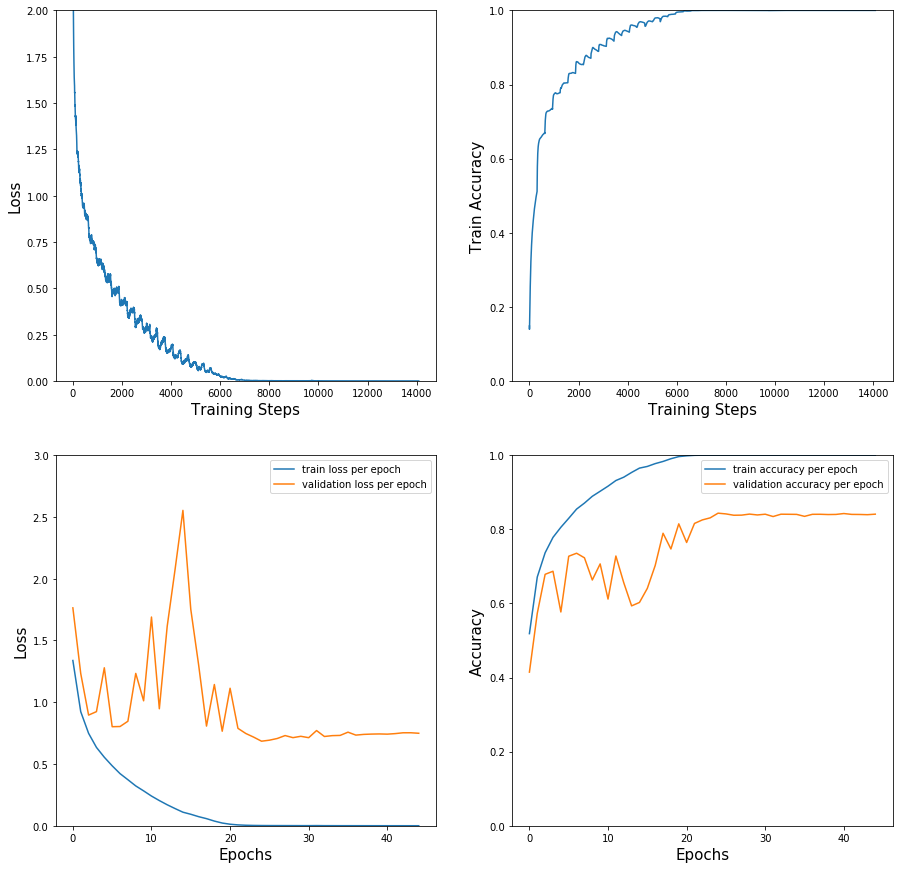

In [19]:
plot(cnn_batch_stats)

In [20]:
test_loss, test_acc = cnn_model.evaluate(x_test, y_test)
print('Test acc = ', test_acc)

10000/10000 [==============================] - 2s 214us/sample - loss: 0.8052 - acc: 0.8325
Test acc =  0.8325


In [23]:
saved_model = load_model(model_path)
test_loss, test_acc = saved_model.evaluate(x_test, y_test)
print('Test acc = ', test_acc)

10000/10000 [==============================] - 2s 199us/sample - loss: 0.7378 - acc: 0.8332
Test acc =  0.8332
